In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ... Read the file
data=pd.read_csv('test_info.csv', index_col=0)
data['action_date']=pd.to_datetime(data.action_date)
data=data.sort_values('action_date')

In [3]:
# ... Look at the data
data.head()

,user_id_sender,reg_date_sender,gender_sender,country_sender,age_sender,user_id_receiver,reg_date_receiver,gender_receiver,country_receiver,age_receiver,action_date,chat_type
num,,,,,,,,,,,,
22782,711,2014-11-20 15:30:58,Female,D,27,5148,2015-05-06 16:58:30,Male,G,44,2016-01-01 00:00:07,1
41920,1083,2014-06-09 07:19:04,Male,E,58,7747,2015-10-13 12:06:18,Female,D,38,2016-01-01 00:00:08,1
1600186,8693,2015-11-15 05:06:00,Male,A,46,705,2014-05-28 11:14:24,Female,D,40,2016-01-01 00:00:12,1
41921,1083,2014-06-09 07:19:04,Male,E,58,7747,2015-10-13 12:06:18,Female,D,38,2016-01-01 00:00:12,1
1262861,7747,2015-10-13 12:06:18,Female,D,38,1083,2014-06-09 07:19:04,Male,E,58,2016-01-01 00:00:14,1


In [4]:
# ... Let's look how many users send messages:
data.user_id_sender.drop_duplicates().count()

4879

In [5]:
# ... Let's look how many users receive messages:
data.user_id_receiver.drop_duplicates().count()

18994

In [6]:
# ... Oh, number of users that received messages is much bigger then number of users who sent messages.
# ... It looks like a lot of inactive users or users who don't want to pay received messages (but is is just an assumption)
# ... I think audience should be defined as users who sent at least one message

In [7]:
# ... Get audience
audience=data[['user_id_sender', 'reg_date_sender', 'gender_sender', 'country_sender', 'age_sender']].drop_duplicates()

Text(0.5,0,'Age')

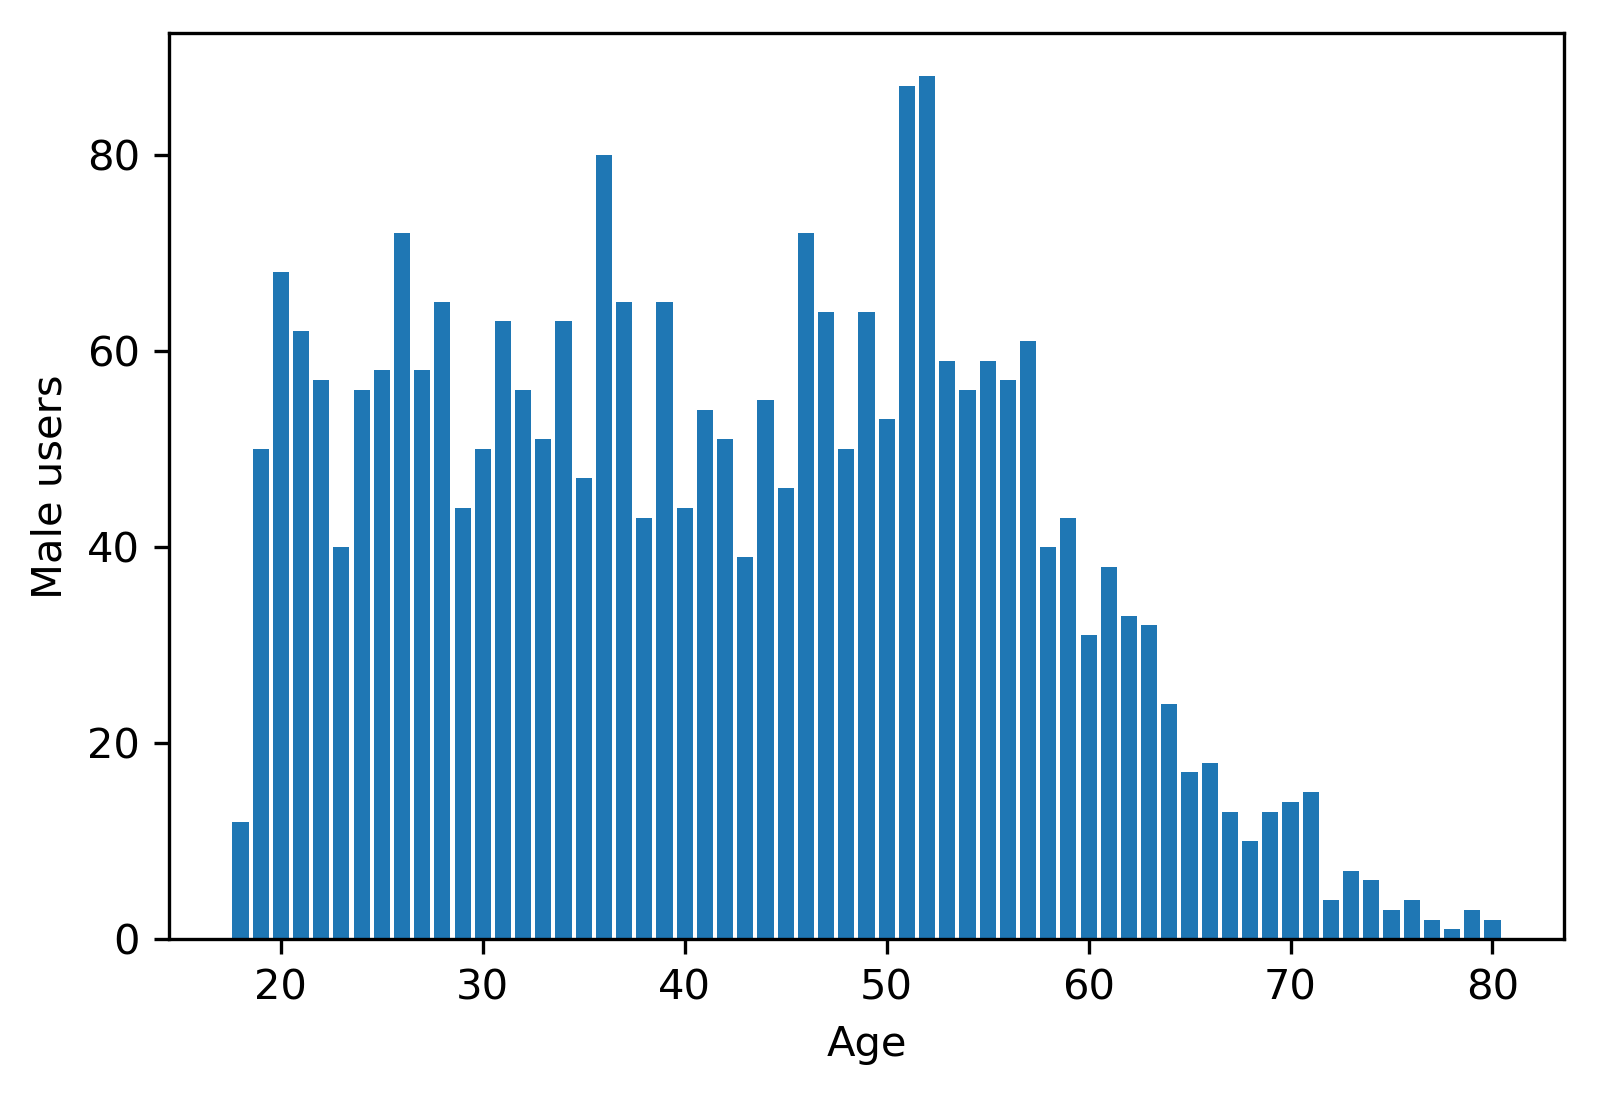

In [8]:
# ... Males audience by age
males=audience.ix[audience.gender_sender=='Male'].age_sender.value_counts()
males=males.sort_index()

fig=plt.figure(dpi=300)
ax1=fig.add_subplot(1,1,1)
ax1.bar(males.index, males.values)
ax1.set_ylabel('Male users')
ax1.set_xlabel('Age')

In [9]:
# ... So we can see that males audience is uniformly distributed in range from 19 to 57
# ... years and then number of users go down by normal distribution

Text(0.5,0,'Age')

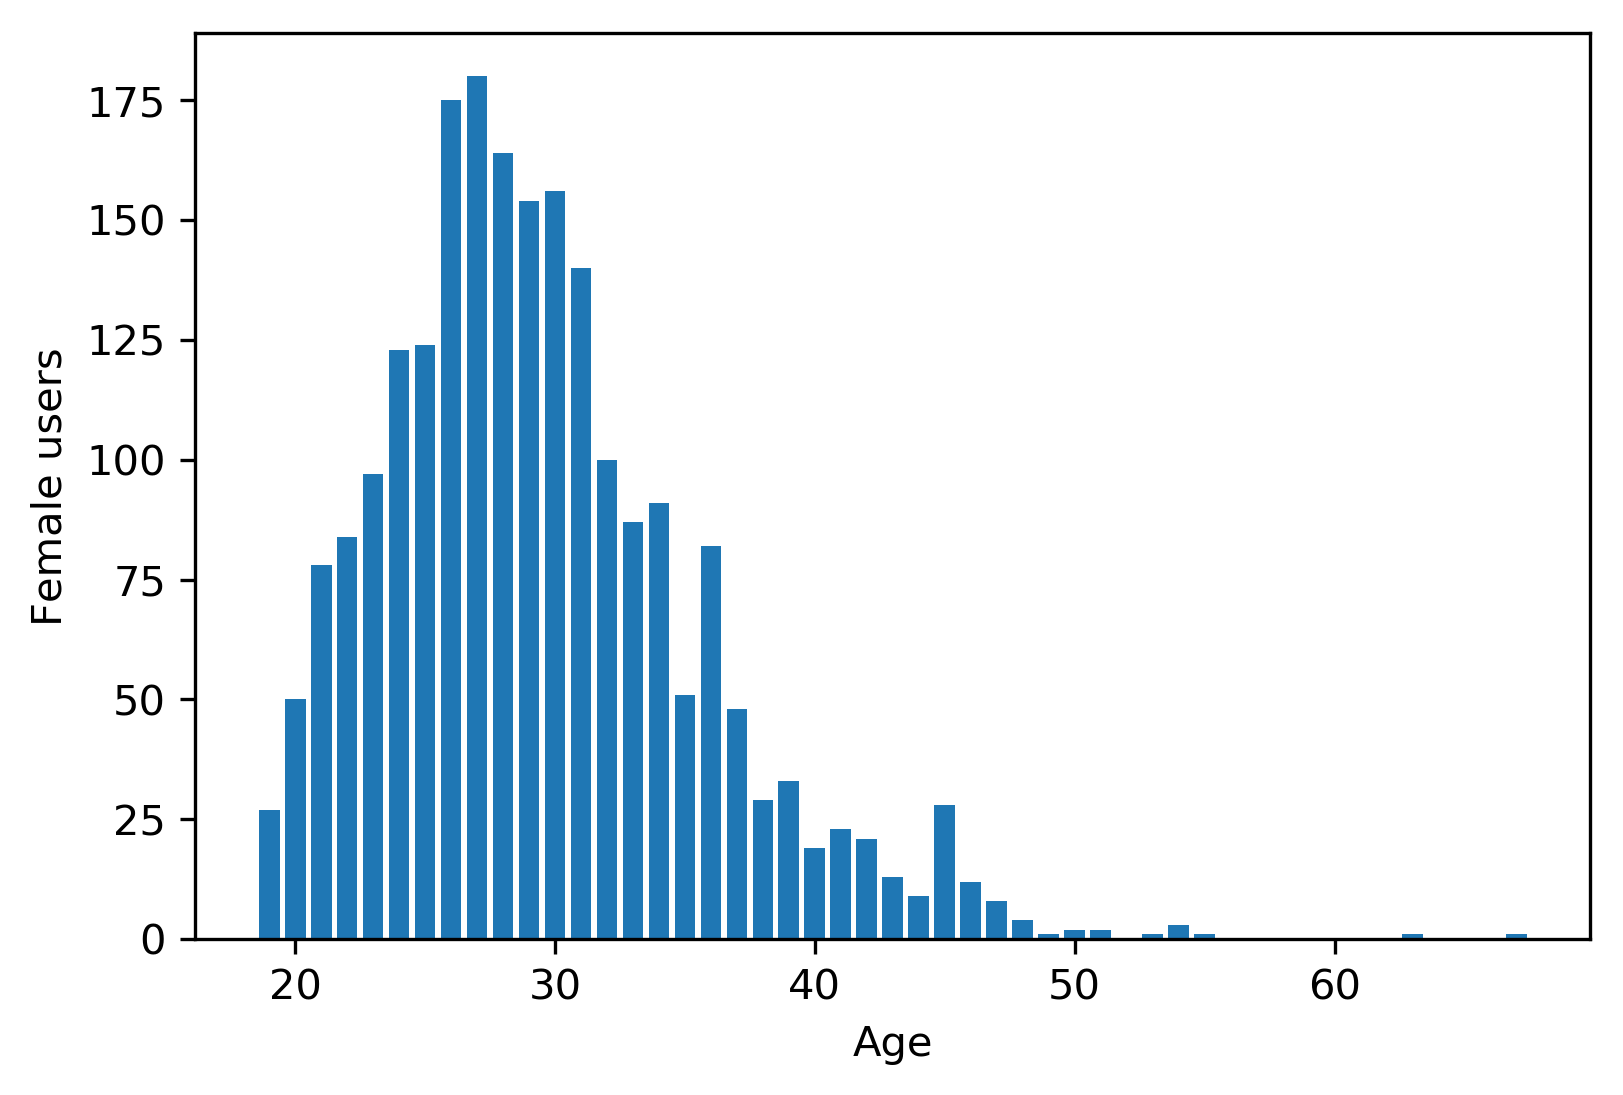

In [10]:
# ... Females audience by age
females=audience.ix[audience.gender_sender=='Female'].age_sender.value_counts()
females=females.sort_index()

fig=plt.figure(dpi=300)
ax1=fig.add_subplot(1,1,1)
ax1.bar(females.index, females.values)
ax1.set_ylabel('Female users')
ax1.set_xlabel('Age')

In [11]:
# ... Females are distributed normally by age with a peek in a range from 25 to 30.

In [12]:
# ... Males audience by country
males=audience.ix[audience.gender_sender=='Male'].country_sender.value_counts()
males=males.sort_values(ascending=False)
(males*100/males.sum()).round(2)[:10]

A    54.80
B    14.11
C    11.33
E     7.08
D     4.70
F     3.46
L     0.64
G     0.41
K     0.34
H     0.34
Name: country_sender, dtype: float64

In [13]:
# ... females audience by country
females=audience.ix[audience.gender_sender=='Female'].country_sender.value_counts()
females=females.sort_values(ascending=False)
(females*100/females.sum()).round(2)[:10]

D    75.70
W     7.70
V     7.07
X     6.71
B     2.25
A     0.45
E     0.05
O     0.05
F     0.05
Name: country_sender, dtype: float64

In [14]:
# ... Men's audience is located mainly in 'A' country (USA?), and also a lot of users present in 'B', 'C', 'D', 'E'. 'F' countries
# ... Womens audience mainly located in 'D' country (Ukraine?), and also present at 'v', 'W', 'Z')

In [15]:
# ... Find number of messages sent by males and females
print('Messages sent:\n',data.gender_sender.value_counts() )
print('Audience:\n', audience.gender_sender.value_counts())

Messages sent:
 Female    1999887
Male       118102
Name: gender_sender, dtype: int64
Audience:
 Male      2657
Female    2222
Name: gender_sender, dtype: int64


In [16]:
# ... Oh, females sent messages 17 times more often then males.
# ... In the same time Male audience is higher then Female one.
# ... Looks strange. We will try to find explanation later

In [17]:
# ... Let's look on first and last message sended:
print('First message:', data.action_date.min())
print('Last message :', data.action_date.max())

First message: 2016-01-01 00:00:07
Last message : 2016-02-01 00:00:00


In [18]:
# ... So we have a data for January, 2016

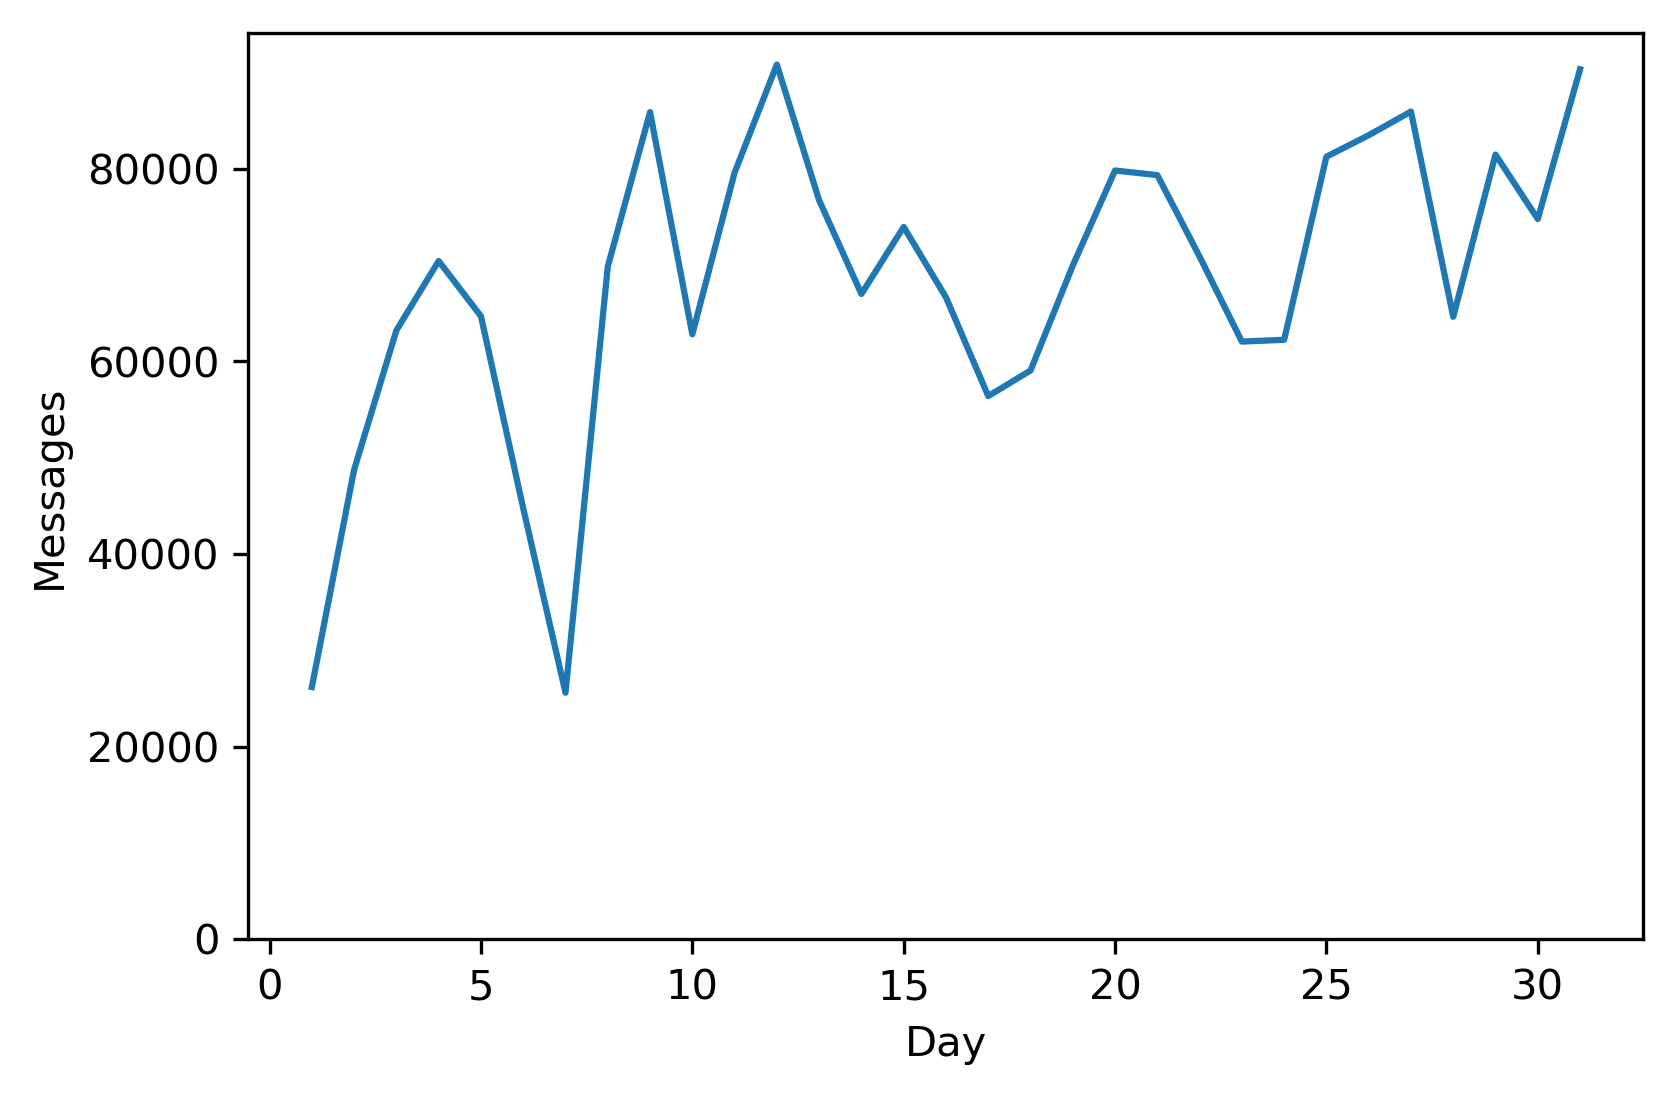

In [19]:
# ... Build a plot for day by day changing in activity
data['day']=data.action_date.map(lambda x: x.day if x.month==1 else 31)  # we have one message on 01-02-2016 00:00:00, just assume that it was sent on Jan,31
num_msg_day=data.day.value_counts().sort_index()
fig=plt.figure(dpi=300)
ax1=fig.add_subplot(1,1,1)
ax1.plot(num_msg_day.index, num_msg_day.values)
ax1.set_xlabel('Day')
ax1.set_ylabel('Messages')
ax1.set_ybound(0)

In [20]:
# ... We see that Jan, 1 and Jan, 7 are the most "inactive" days in January. 
# ... Looks like it caused by public holidays in Ukraine. But why users are so inactive at non-working day?

In [21]:
# ... Find average number of messages per minute:
print('Messages per minute:', np.round(data.action_date.count()/31/24/60,2))

Messages per minute: 47.45


In [22]:
# ... Get biggest gaps between messages
msg_dates=data.action_date
next_msg_dates=msg_dates[1:].append(msg_dates[-1:])
next_msg_dates.index=msg_dates.index
deltas=(next_msg_dates-msg_dates).sort_values(ascending=False)
print(deltas[:10])

num
301199    00:30:02
47745     00:08:20
785450    00:07:26
434020    00:05:56
2003216   00:05:38
785413    00:05:03
1159992   00:04:52
2003089   00:04:44
42685     00:04:29
915482    00:04:22
Name: action_date, dtype: timedelta64[ns]


In [23]:
# ... Biggest gap is too extreme and much continued then next ones.

In [24]:
print('Error gap started:', msg_dates[301199])
print('Error gap ebded:', next_msg_dates[301199])

Error gap started: 2016-01-26 07:17:52
Error gap ebded: 2016-01-26 07:47:54


In [25]:
# ... So we can see that there was a 30-minute problem with a website on 26, Jan 2016 from 7:17 to 7:47

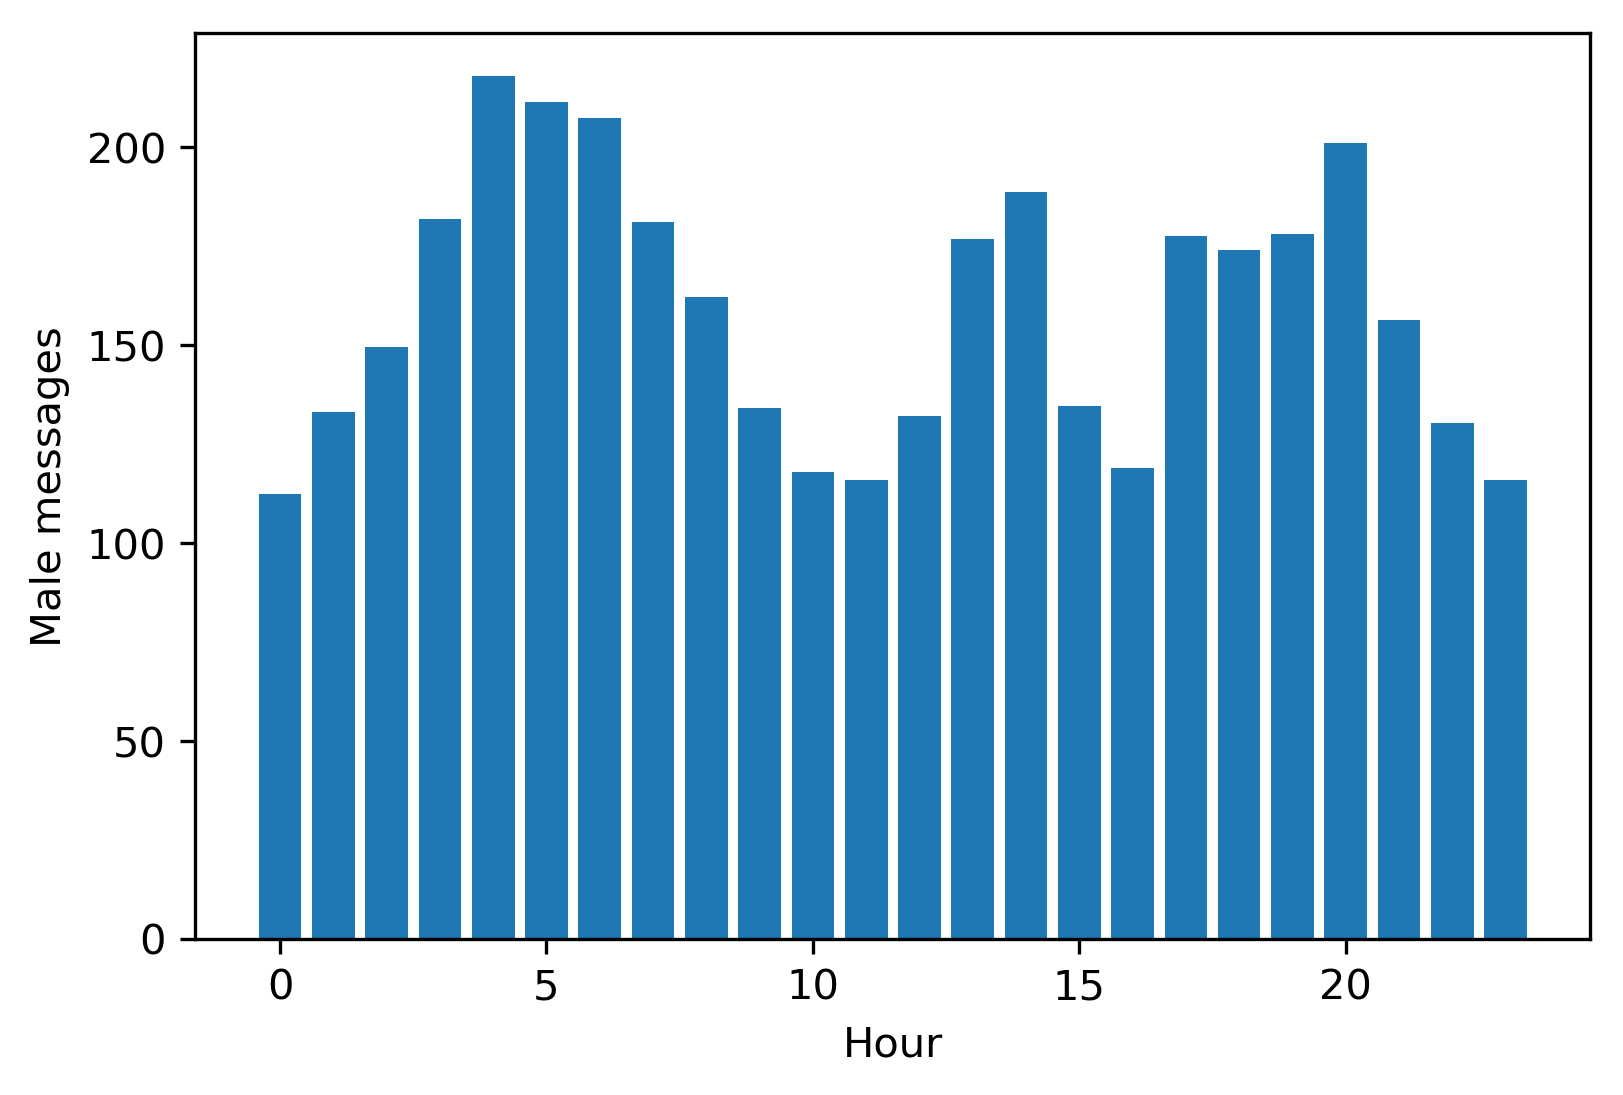

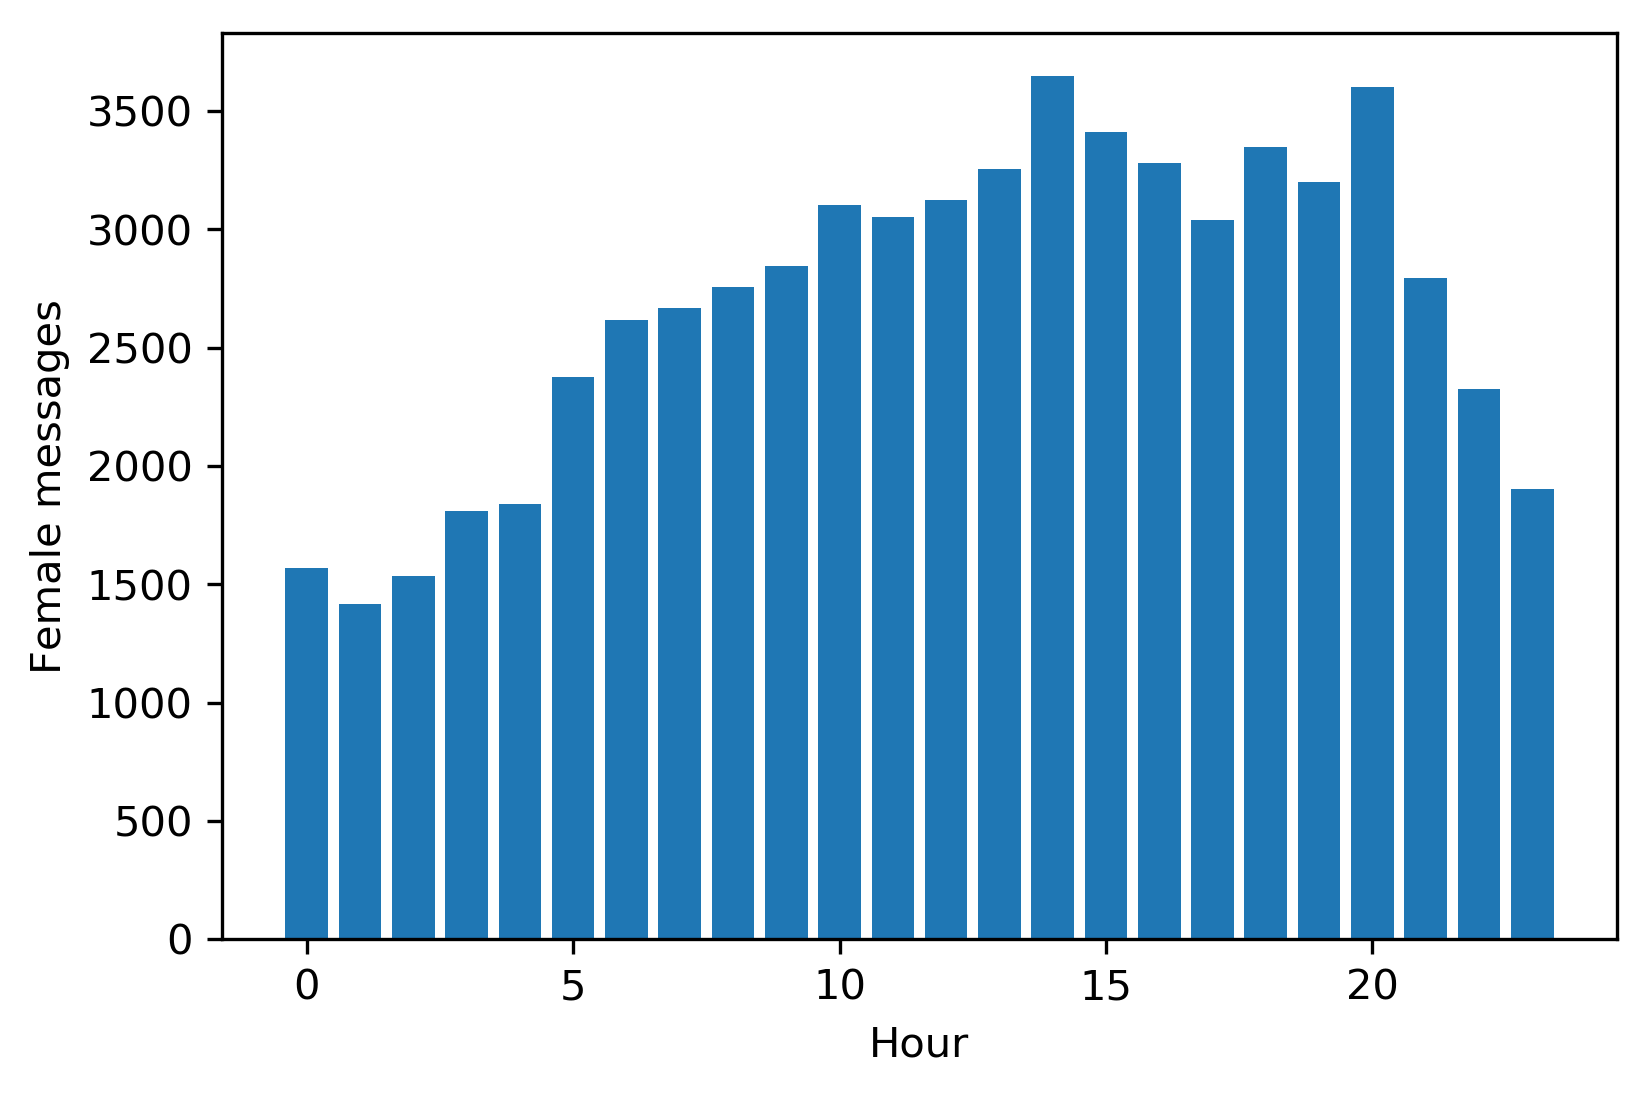

In [26]:
# ... Let's look on hourly male and female activity
data['hour']=data.action_date.map(lambda x: x.hour)

# ... Male activity:
num_msg_hour=data.ix[data.gender_sender=='Male'].hour.value_counts().sort_index()/31
fig=plt.figure(dpi=300)
ax1=fig.add_subplot(1,1,1)
ax1.bar(num_msg_hour.index, num_msg_hour.values)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Male messages')

# ... Female activity:
num_msg_hour=data.ix[data.gender_sender=='Female'].hour.value_counts().sort_index()/31
fig=plt.figure(dpi=300)
ax1=fig.add_subplot(1,1,1)
ax1.bar(num_msg_hour.index, num_msg_hour.values)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Female messages')

del data['hour']

In [27]:
# ... For male audience we see 2 peaks (4-6 and 17-21, looks like USA and Europe)
# ... For female audience data mor plain but highest activity is on 10-21 hours (Ukraine)

In [28]:
# ... Build a dyalogue data based on message info

In [29]:
# ... Find male and female dyalog participants

# ... apply is too slow
#get_gender_cols=['user_id_sender', 'gender_sender', 'user_id_receiver', 'gender_receiver']
#data['male_id']=data[get_gender_cols].apply((lambda x : x[0] if x[1]=='Male' else x[2]), axis=1)
#data['female_id']=data[get_gender_cols].apply((lambda x : x[0] if x[1]=='Female' else x[2]), axis=1)

data['male_id']=-1
data['female_id']=-1
male_msgs=data.gender_sender=='Male'
data['male_id'].ix[male_msgs]=data['user_id_sender'].ix[male_msgs]
data['female_id'].ix[male_msgs]=data['user_id_receiver'].ix[male_msgs]
data['male_id'].ix[~male_msgs]=data['user_id_receiver'].ix[~male_msgs]
data['female_id'].ix[~male_msgs]=data['user_id_sender'].ix[~male_msgs]

In [30]:
dyalogs=data.pivot_table(values='gender_sender', index=['male_id', 'female_id'], aggfunc='count')
dyalogs.columns=['num_of_msg']
dyalogs=dyalogs.reset_index()
dyalogs=dyalogs.merge(data[['male_id', 'female_id', 'gender_sender', 'action_date', 'chat_type']], how='outer', on=['male_id', 'female_id'])
dyalogs=dyalogs.drop_duplicates(['male_id', 'female_id'])  # ... leave info about first message in a dyalogue
dyalogs.columns=['male_id', 'female_id', 'num_of_msg', 'gender_first_sender', 'action_first_date', 'chat_type_first']
dyalogs=dyalogs.merge(data[['male_id', 'female_id', 'gender_sender', 'action_date', 'chat_type']], how='outer', on=['male_id', 'female_id'])
dyalogs=dyalogs.drop_duplicates(['male_id', 'female_id'], keep='last')  # ... leave info about last message in a dyalogue
dyalogs.columns=['male_id', 'female_id', 'num_of_msg', 'gender_first_sender', 'action_first_date', 'chat_type_first', 'gender_last_sender', 'action_last_date', 'chat_type_last']


In [31]:
# ... Get number of messages sent by each user in dyalogue:
msg=data.pivot_table(values='age_sender', index=['male_id', 'female_id'], columns='gender_sender', aggfunc='count', fill_value=0)
msg.columns=['female_msg', 'male_msg']
msg=msg.reset_index()

In [32]:
# ... Add number of messages info into dyalogue dataframe
dyalogs=dyalogs.merge(msg, on=['male_id', 'female_id'])   

# ... Add new feature which describes whether two persons in a dyalogue communicated (send messages) or not
dyalogs['isdyal']=dyalogs[['female_msg', 'male_msg']].apply(lambda x: 1 if ((x[0]>0)&(x[1]>0)) else 0, axis=1)

In [33]:
# ... See how many dyalogs successfull
print(dyalogs.isdyal.value_counts())

0    1340647
1       9162
Name: isdyal, dtype: int64


In [34]:
# ... There was only 9162 real dyalogues. In another 1340647 dyalogues was only 1 active participant.

In [35]:
# ... Let's go deeply
piv_dyalogs=dyalogs[['male_id','gender_first_sender', 'chat_type_first', 'isdyal']].pivot_table(values='male_id', index=['gender_first_sender', 'chat_type_first'], columns='isdyal', aggfunc='count', fill_value=0)
piv_dyalogs['pct']=(piv_dyalogs[1]/(piv_dyalogs[0]+piv_dyalogs[1])*100).round(2)
print(piv_dyalogs)

isdyal                                    0     1    pct
gender_first_sender chat_type_first                     
Female              1                418171  2461   0.59
                    2                831630   953   0.11
                    3                   154     0   0.00
                    4                 82491   160   0.19
Male                1                   532  1112  67.64
                    3                  7666  4471  36.84
                    4                     3     5  62.50


In [36]:
# ... In column 'pct' you can see persentage of successful dyalog intializations (when respond was sent) per gender and chat type
# ... As you see, males are much more successful in dyalog starting. Also dyalogs started from message with chat type 1 
# ... are more likely to be continued.

In [37]:
# ... Strnage issue was found for dyalogue between users 4574 and 4368.
# ... There are 4776 messages from male and 0 messages from female. looks very strange and need to be rechecked with additional information
dyalogs.sort_values(by='num_of_msg', ascending=False)[:10]

,male_id,female_id,num_of_msg,gender_first_sender,action_first_date,chat_type_first,gender_last_sender,action_last_date,chat_type_last,female_msg,male_msg,isdyal
244585,3866,5072,6679,Female,2016-01-01 10:21:27,1,Female,2016-01-31 21:28:30,1,3889,2790,1
232959,3720,2407,6484,Female,2016-01-03 06:28:13,1,Female,2016-01-31 05:55:48,1,3693,2791,1
299740,4979,4968,6403,Male,2016-01-01 16:50:31,1,Female,2016-01-31 20:15:32,1,2790,3613,1
257996,4129,5685,5202,Male,2016-01-01 12:06:37,1,Male,2016-01-31 22:04:52,1,2572,2630,1
271137,4412,6003,4863,Female,2016-01-03 12:50:44,1,Female,2016-01-31 14:56:39,1,2545,2318,1
281812,4574,4368,4776,Male,2016-01-01 22:52:56,1,Male,2016-01-31 23:39:37,1,0,4776,0
299048,4977,4968,4409,Female,2016-01-01 07:35:14,1,Male,2016-01-31 23:04:13,1,2176,2233,1
219456,3463,7122,3438,Male,2016-01-01 00:00:51,1,Female,2016-01-31 22:58:38,1,1639,1799,1
244516,3866,3943,3407,Female,2016-01-01 00:56:53,1,Female,2016-01-31 21:27:56,1,1908,1499,1
271823,4420,8263,3229,Female,2016-01-03 09:06:34,1,Female,2016-01-31 13:29:00,1,1833,1396,1


In [38]:
# ... For future analysis we need only dyalogues where both participants sent messages. Remove non-relevant information:
dyalogs=dyalogs.ix[dyalogs.isdyal==1]
del dyalogs['isdyal']

In [39]:
# ... Ad unique identificator for dyalogues
dyalogs.reset_index(drop=True, inplace=True)
dyalogs['dyalog_id']=dyalogs.index+1

In [40]:
# ... Find time for response on message in each dyalogue
data=data.merge(dyalogs[['male_id', 'female_id', 'dyalog_id']], how='left', on=['male_id', 'female_id'])
data=data.ix[data.dyalog_id.notnull()]
data['dyalog_id']=data.dyalog_id.astype(int)
data.sort_values(by=['dyalog_id', 'action_date'], inplace=True)
first_msg_data=data.drop_duplicates(subset=['gender_sender', 'dyalog_id'])
next_dyal_msg_day=first_msg_data.action_date[1:].append(first_msg_data.action_date[-1:])
next_dyal_msg_day.index=first_msg_data.index
first_msg_data['next_dyal_msg_day']=next_dyal_msg_day
first_msg_data['time_to_answer']=first_msg_data.next_dyal_msg_day-first_msg_data.action_date
first_msg_data=first_msg_data[['dyalog_id', 'time_to_answer']].drop_duplicates(subset='dyalog_id')
dyalogs=dyalogs.merge(first_msg_data, how='left', on='dyalog_id')
dyalogs['days_to_answer']=dyalogs.time_to_answer.map(lambda x: x.days)
dyalogs['seconds_to_answer']=dyalogs.time_to_answer.map(lambda x: x.seconds)
dyalogs['hours_to_answer']=dyalogs.seconds_to_answer.floordiv(3600)

In [41]:
# ... Build a groups for message response:
# ... - less then 10 minutes
# ... - from 10 minutes to 1 hour
# ... - from 1 to 5 hour
# ... - from 5 hours to 1 day
# ... - from 1 dat to 5 days
# ... - more then 5 days
dyalogs['time_group']=np.nan
dyalogs['time_group'].ix[dyalogs.seconds_to_answer<600]='less5min'
dyalogs['time_group'].ix[(dyalogs.time_group.isnull())&(dyalogs.hours_to_answer<1)]='less1hour'
dyalogs['time_group'].ix[(dyalogs.time_group.isnull())&(dyalogs.hours_to_answer<5)]='less5hour'
dyalogs['time_group'].ix[(dyalogs.time_group.isnull())&(dyalogs.days_to_answer<1)]='less1day'
dyalogs['time_group'].ix[(dyalogs.time_group.isnull())&(dyalogs.days_to_answer<5)]='less5day'
dyalogs['time_group'].ix[dyalogs.time_group.isnull()]='more5day'

Text(0.5,1,'Feales')

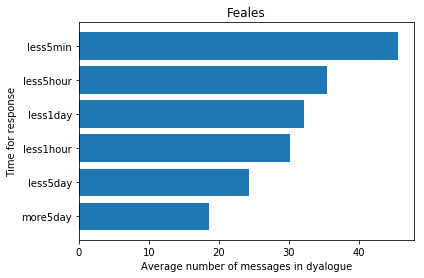

In [42]:
# ... Analyze dyalogs where males and females were initializers separately
# ... Start from females
females_time_groups=dyalogs.ix[dyalogs.gender_first_sender=='Female'].groupby('time_group').female_msg.mean().sort_values()
fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
ax1.barh(females_time_groups.index, females_time_groups.values)
ax1.set_xlabel('Average number of messages in dyalogue')
ax1.set_ylabel('Time for response')   # ... Time between dyalogue initializing and receiver first response
ax1.set_title('Feales')

Text(0.5,1,'Males')

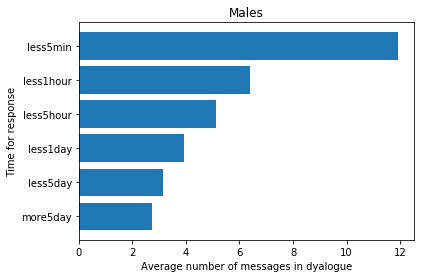

In [43]:
# ... And males
males_time_groups=dyalogs.ix[dyalogs.gender_first_sender=='Male'].groupby('time_group').female_msg.mean().sort_values()
fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
ax1.barh(males_time_groups.index, males_time_groups.values)
ax1.set_xlabel('Average number of messages in dyalogue')
ax1.set_ylabel('Time for response')   # ... Time between dyalogue initializing and receiver first response
ax1.set_title('Males')

In [44]:
# ... We see almost identical situation in both cases: dyalogue is deeper if first response is fast.
# ... So we need notify users about inbox messages as soon as possible ( and via different possible communication channels)

# ... But one strange point was found. As was shown before, males are much more successful in dyalogues initializing.
# ... But dyalogues initialized by females usually much deeper.

# ... Also we should not forget that we have only 1-month data. So some dyalogues do not contain all relevant messages, 
# ... because part of messages can be sent before analyzed month, and other part can be sent after. 

In [45]:
# ... Let's see who usually startsand ends dyalogue
print(dyalogs.pivot_table(values='num_of_msg', index='gender_first_sender', columns='gender_last_sender', 
                          aggfunc='count', margins=True)/dyalogs.num_of_msg.count()*100)

gender_last_sender      Female      Male        All
gender_first_sender                                
Female               34.108273  4.900677   39.00895
Male                 59.670378  1.320672   60.99105
All                  93.778651  6.221349  100.00000


In [46]:
# ... We see that males a little bit often (61% vs 39%) starts communication. But females almost always (~94%)
# ... ends communication
# ... As shown before, males are much more succeeful in dyalogues initializing, 
# ... but dyalogues initialized by females are more vital (if dyalogue was initialized)

In [47]:
# ... Remove non-relevant information 
del dyalogs['time_to_answer']
del dyalogs['days_to_answer'] 
del dyalogs['seconds_to_answer']
del dyalogs['hours_to_answer']


In [48]:
# ... Get dialogue life time
dyalogs['life_time']=dyalogs.action_last_date-dyalogs.action_first_date
dyalogs['life_days']=dyalogs.life_time.map(lambda x: x.days)
dyalogs['life_seconds']=dyalogs.life_days*86400+dyalogs.life_time.map(lambda x: x.seconds)

In [49]:
# ... Apply k-means for clusterization
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, init='random', n_init=1, random_state=3)
trainm=dyalogs[['life_seconds','num_of_msg']]
trainm['num_of_msg']=np.power(trainm.num_of_msg,0.1)
trainm['life_seconds']=np.power(trainm['life_seconds'],0.5)/3000
km.fit(trainm)
dyalogs['kmlabels']=km.labels_

Text(0.5,1,'Groups per duration of communiction and number of messages')

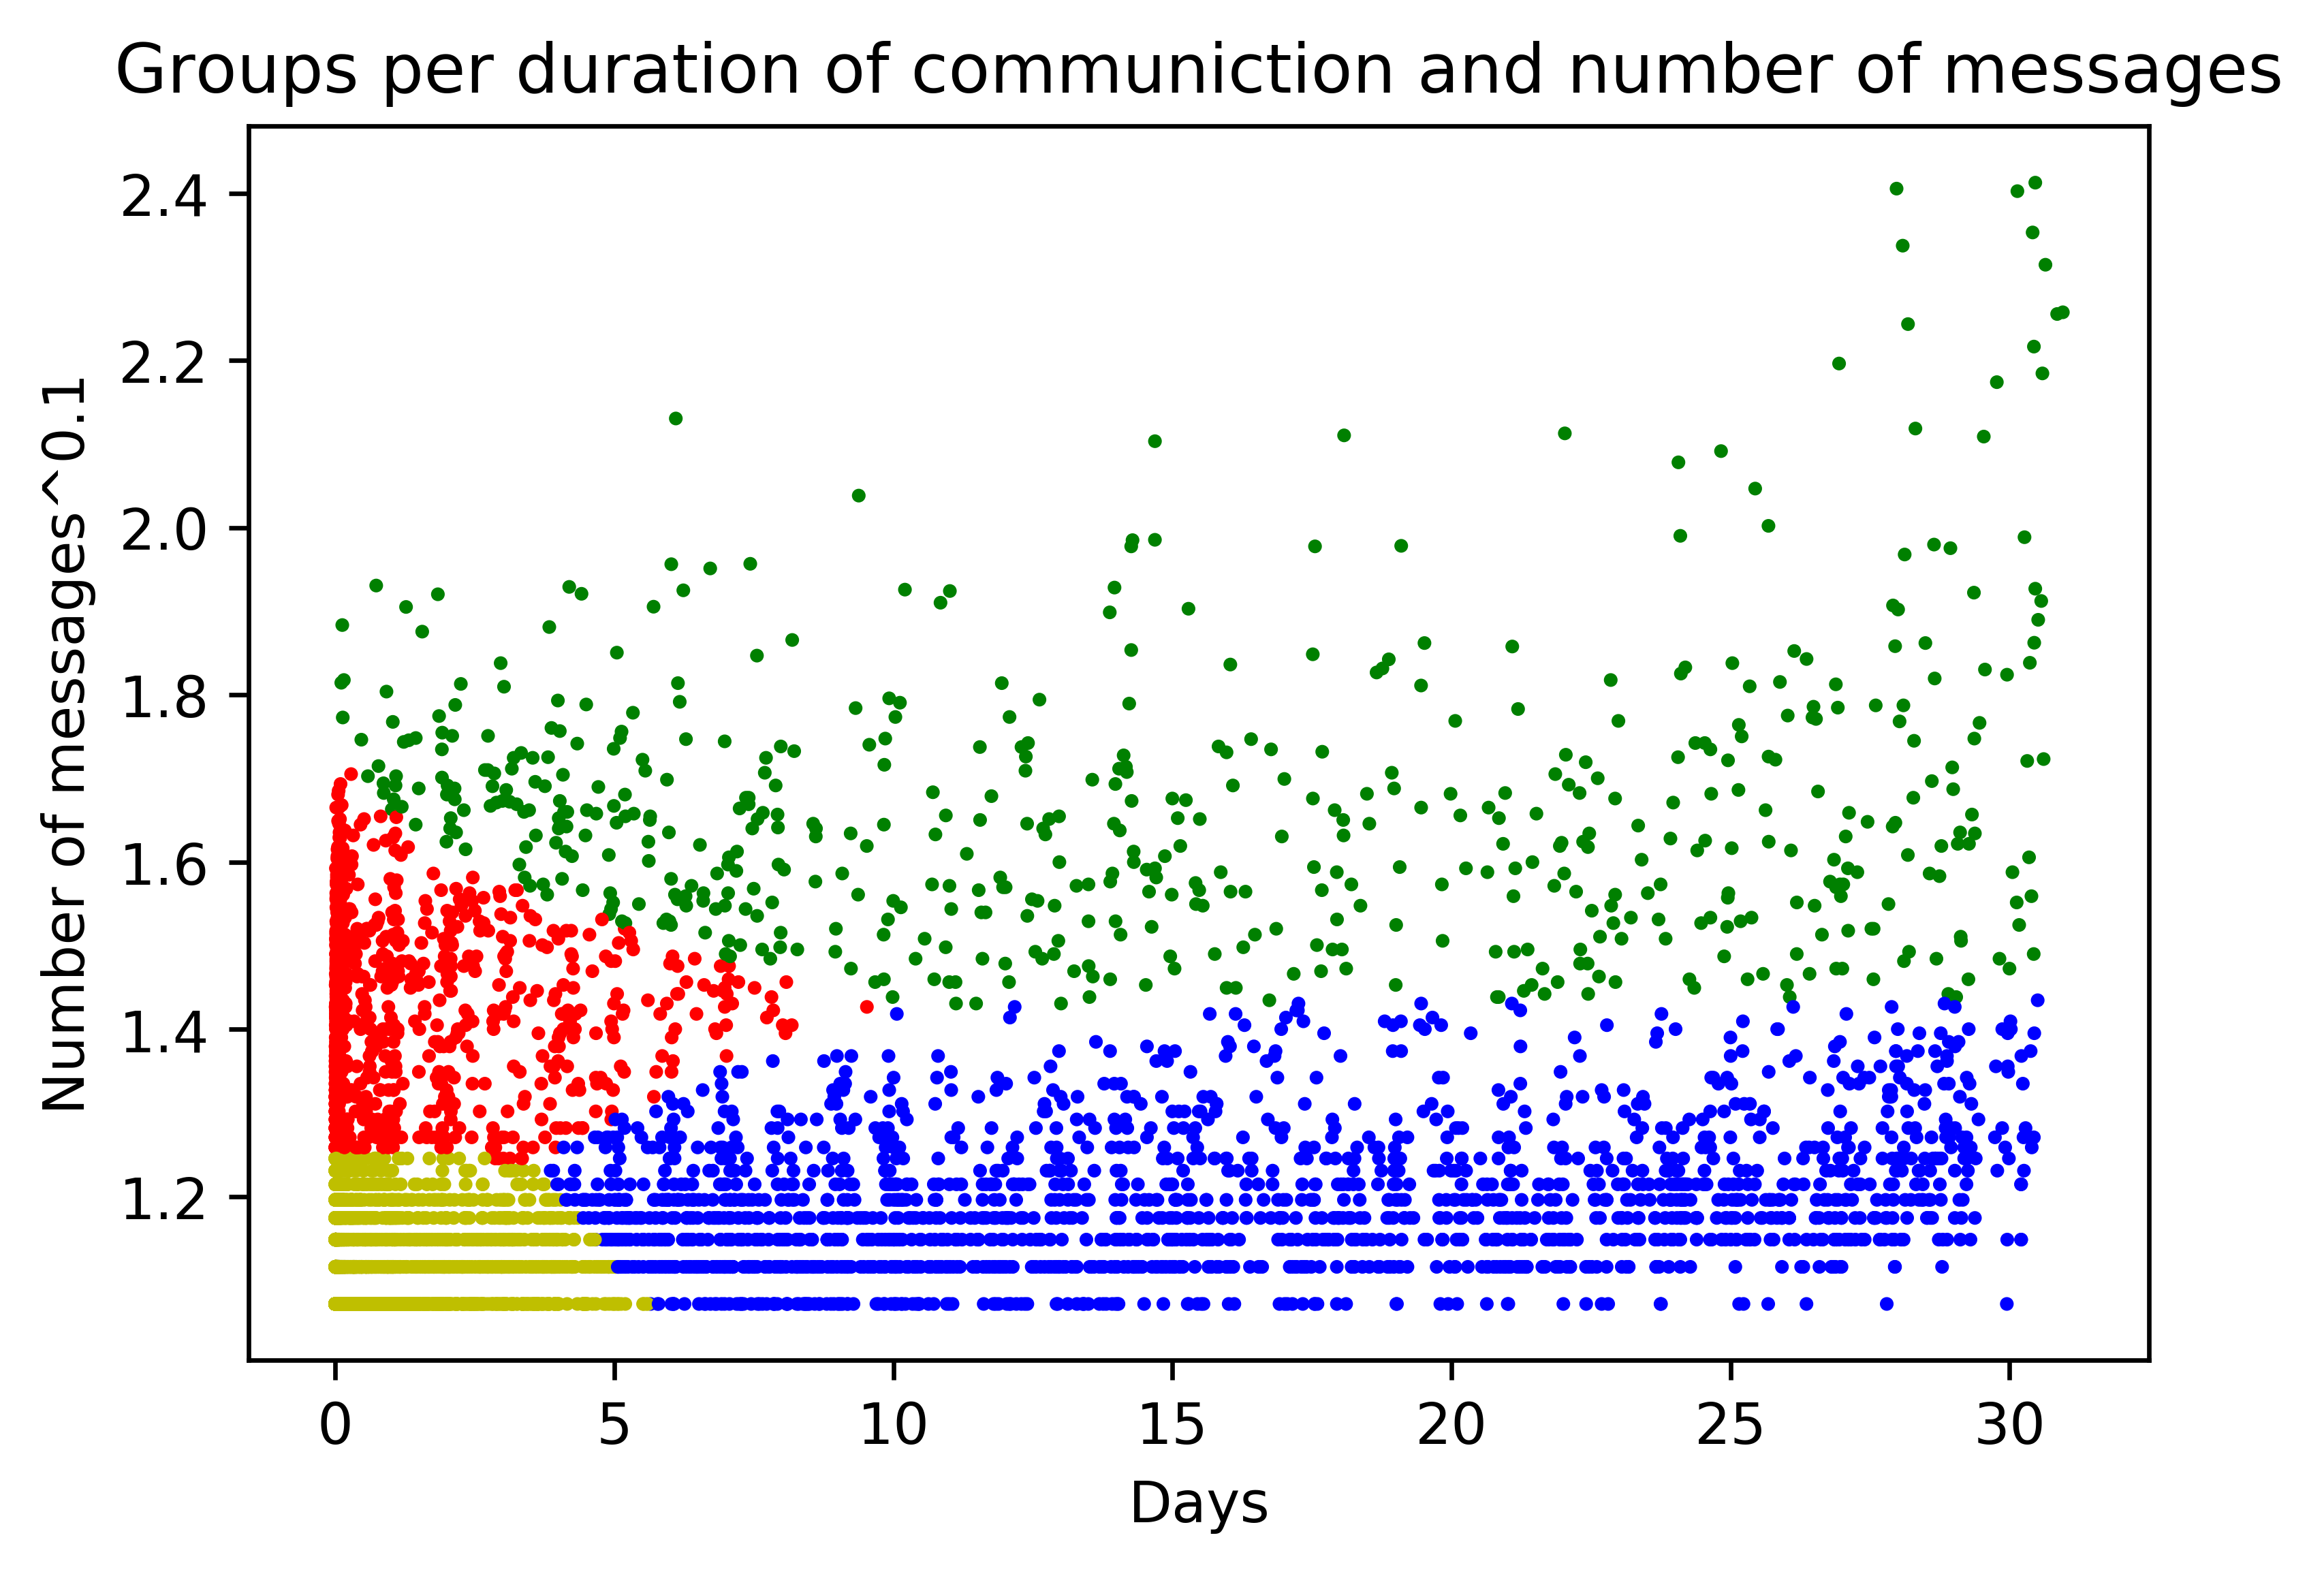

In [50]:
# ... Build a graph that illustrate result of clusterization
colours={0:'r', 1:'b', 2:'g', 3:'y'}
feature_colours=dyalogs.kmlabels.map(colours)
fig=plt.figure(dpi=600)
ax1=fig.add_subplot(1,1,1)
ax1.scatter(dyalogs.life_seconds/86400,trainm.num_of_msg, s=2, c=feature_colours)
ax1.set_xlabel('Days')
ax1.set_ylabel('Number of messages^0.1')
ax1.set_title('Groups per duration of communiction and number of messages')

# ... To better illustrate y coordinate was setted as num_of_msg^0.1 instead of num_of_msg

Text(0.5,1,'Groups per duration of communiction and number of messages')

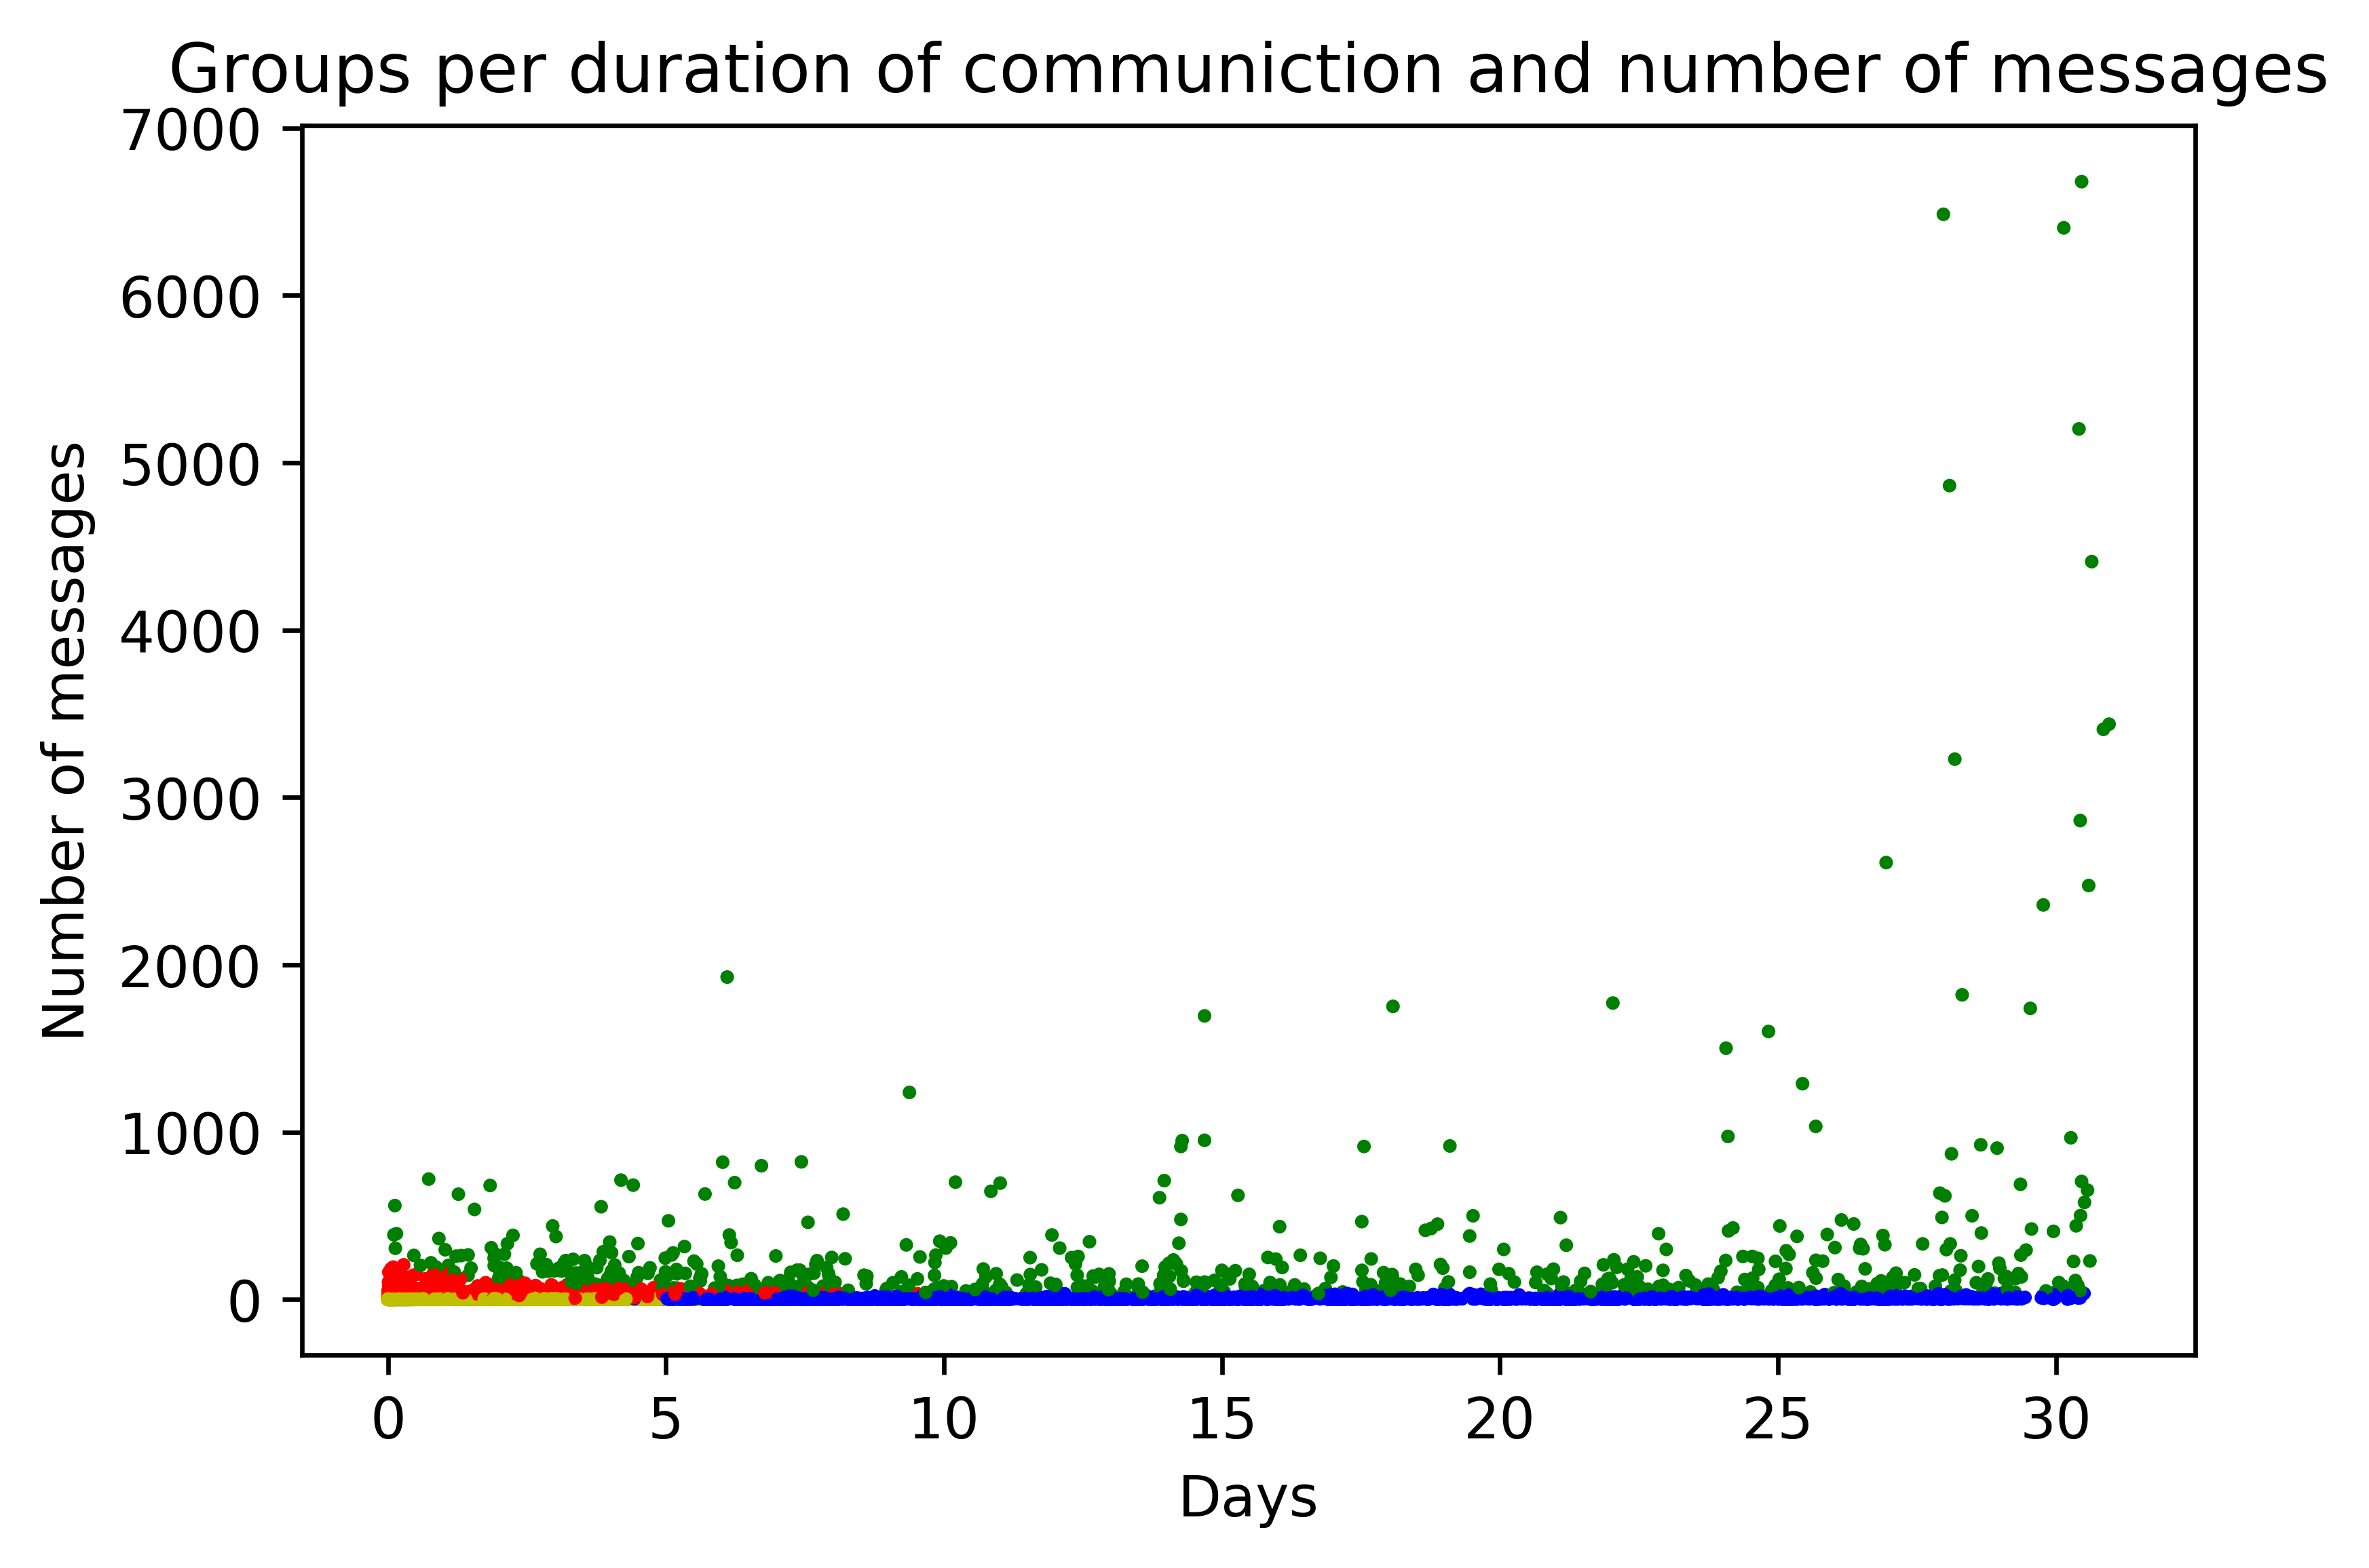

In [51]:
# ... Build the same graph in real coordinates
fig=plt.figure(dpi=600)
ax1=fig.add_subplot(1,1,1)
ax1.scatter(dyalogs.life_seconds/86400,dyalogs.num_of_msg, s=2, c=feature_colours)
ax1.set_xlabel('Days')
ax1.set_ylabel('Number of messages')
ax1.set_title('Groups per duration of communiction and number of messages')

In [52]:
# ... Communication was splitted into 4 groups:
# ... - group with short duration and low number of messages (yellow)
# ... - group with long duration and low number of messages (blue)
# ... - group with short duration and medium number of messages (red)
# ... - group with big number of messages (green)

In [53]:
# ... Based on data I can assume that it is a dating website where females are much more active then males.
# ... It looks like they try to invoke males to communication, but low level of response says that 
# ... responding is not free (it also can be that female try to communicate to inactive users, but I think it is not a case).
# ... What for males pay money to communicate? Just for chat? But there is a lot of free analogues to do it, so 
# ... I'm not sure that males are interested in typical chating. What it can be? I can just assume that it is 
# ... something like wedding agency or specific dating website.